This guest post by Paolo Tosco (GitHub: @ptosco), one of the RDKit core maintainers, is the fourth of a few posts covering some of the new or improved features in the 2023.09.1 RDKit release.

A PR of mine dealing with MCS code clean up, refactoring and fixing open bugs has been open for one year or so.<br><br>
The growing sense of guilt, together with new and more exciting bugs being found by myself and others during this year, prompted me to take it up again.<br><br>
Eventually, I managed to complete the PR, which fixed all outstanding MCS-related bugs at the time of PR submission.<br><br>
The PR was merged with no changes.<br>
[A quick glance at the PR will tell you that this was not necessarily due to my impeccable code style.](https://github.com/rdkit/rdkit/pull/6646)

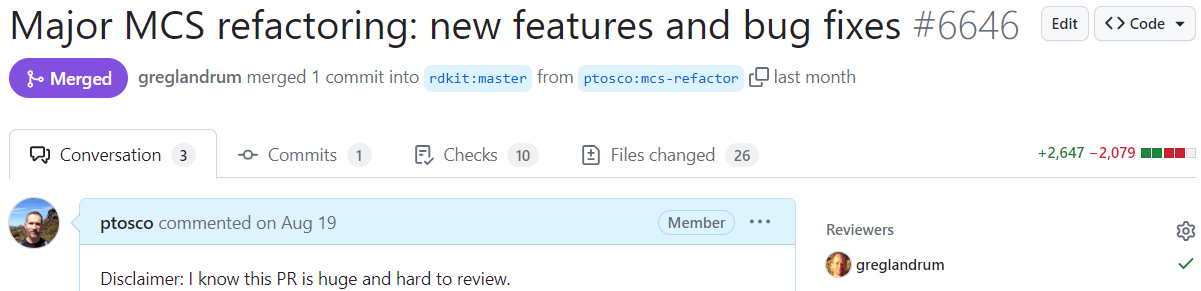

In addition to several bug fixes, the PR introduces significant performance improvements, particularly for difficult MCS cases involving the `CompleteRingsOnly` flag, which now run in finite time rather than just hanging and slowly consuming all of the available memory as they used to.

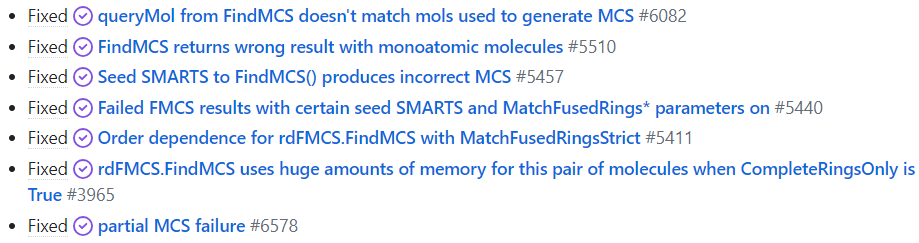

Here I would like to showcase the new features introduced as part of this PR, which relate to requests I had from colleagues as well as from members of the community.

# Custom Python `AtomCompare` and `BondCompare` classes

Actually I have already implemented this feature some time ago, but I am not sure how many users are aware of it; therefore, in the following you will find a quick refresher.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

Let's assume that for some reason we would like to implement a custom MCS criterion that will ignore elements and bond orders/aromaticity in ring systems, while enforcing element and bond order consideration in non-ring portions of the molecules.<br>
This is not something which is readily available among the built-in [AtomCompare](https://rdkit.org/docs/source/rdkit.Chem.rdFMCS.html#rdkit.Chem.rdFMCS.AtomCompare) and [BondCompare](https://rdkit.org/docs/source/rdkit.Chem.rdFMCS.html#rdkit.Chem.rdFMCS.BondCompare) options; therefore, we will need custom subclasses, respectively derived from `AtomCompare` and `BondCompare` classes.

In [2]:
mols = [Chem.MolFromSmiles(smi) for smi in """C[C@H]1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(=O)O
C1[C@@H]2[C@@H](C2N)CN1C3=C(C=C4C(=O)C(=CN(C4=N3)C5=C(C=C(C=C5)F)F)C(=O)O)F
CN(C)CC[C@@](C1=CC=CC2=CC=CC=C21)([C@H](C3=CC=CC=C3)C4=C(N=C5C=CC(=CC5=C4)Br)OC)O
""".split()]

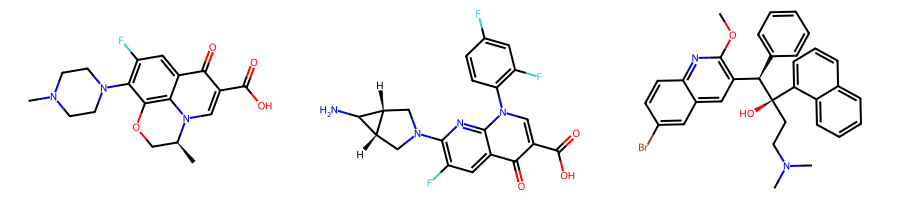

In [3]:
MolsToGridImage(mols, subImgSize=(300, 200))

WIth this rather standard set of parameters, which enforces that ring bonds should only match ring bonds and that rings should be complete, the MCS is 3-methylpyridine:

In [4]:
params = rdFMCS.MCSParameters()
params.AtomTyper = rdFMCS.AtomCompare.CompareElements
params.BondTyper = rdFMCS.BondCompare.CompareOrder
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True

In [5]:
mcs = rdFMCS.FindMCS(mols, params)

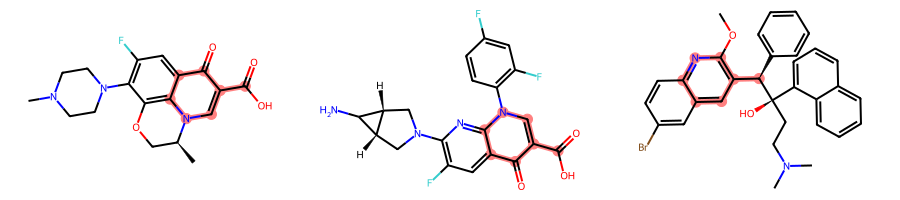

In [6]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

In [7]:
class CompareOrderOutsideRings(rdFMCS.MCSBondCompare):
    def __call__(self, p, mol1, bond1, mol2, bond2):
        b1 = mol1.GetBondWithIdx(bond1)
        b2 = mol2.GetBondWithIdx(bond2)
        if (b1.IsInRing() and b2.IsInRing()) or (b1.GetBondType() == b2.GetBondType()):
            if (p.MatchStereo and not self.CheckBondStereo(p, mol1, bond1, mol2, bond2)):
                return False
            if p.RingMatchesRingOnly:
                return self.CheckBondRingMatch(p, mol1, bond1, mol2, bond2)
            return True
        return False

In [8]:
class CompareElementsOutsideRings(rdFMCS.MCSAtomCompare):
    def __call__(self, p, mol1, atom1, mol2, atom2):
        a1 = mol1.GetAtomWithIdx(atom1)
        a2 = mol2.GetAtomWithIdx(atom2)
        if (a1.GetAtomicNum() != a2.GetAtomicNum()) and not (a1.IsInRing() and a2.IsInRing()):
            return False
        if (p.MatchChiralTag and not self.CheckAtomChirality(p, mol1, atom1, mol2, atom2)):
            return False
        if p.RingMatchesRingOnly:
            return self.CheckAtomRingMatch(p, mol1, atom1, mol2, atom2)
        return True

By using our more lenient atom/bond comparison criterion, while keeping the constraint that ring atoms should only match ring atoms and that rings should be complete, we retrieve a larger MCS:

In [9]:
params = rdFMCS.MCSParameters()
params.AtomTyper = CompareElementsOutsideRings()
params.BondTyper = CompareOrderOutsideRings()
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True

In [10]:
mcs = rdFMCS.FindMCS(mols, params)

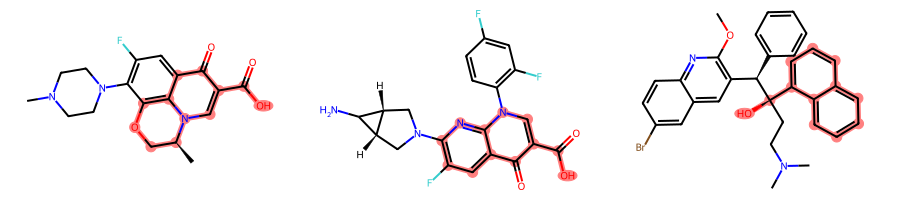

In [11]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

Note that the first molecule can actually match two equivalent ring systems:

In [12]:
[m.GetSubstructMatches(mcs.queryMol) for m in mols]

[((1, 2, 6, 3, 7, 4, 8, 5, 9, 23, 11, 25),
  (5, 4, 6, 14, 7, 13, 8, 12, 9, 23, 11, 25)),
 ((9, 8, 10, 7, 11, 17, 13, 16, 14, 26, 15, 28),),
 ((9, 10, 8, 11, 7, 12, 6, 13, 15, 5, 14, 36),)]

The fact that we instantiate custom compare _classes_ rather than custom compare _functions_ allows to put some non-molecule specific (_i.e._, static) data that we may need for the comparison in addition to the `MCSParameters` that get passed to the `__call__` method by the MCS code.<br>
We may access this data stored on the class instance inside the `__call__` method.<br>
For example, let's assume that we want to enforce that aromatic only matches aromatic based on a user-specified setting.<br>
All we need to do is modify our `CompareOrderOutsideRings` as follows:

In [13]:
class CompareOrderOutsideRings(rdFMCS.MCSBondCompare):
    def __init__(self, aromatic_match_aromatic=False):
        super().__init__()
        self.aromatic_match_aromatic = aromatic_match_aromatic

    def __call__(self, p, mol1, bond1, mol2, bond2):
        b1 = mol1.GetBondWithIdx(bond1)
        b2 = mol2.GetBondWithIdx(bond2)
        if ((b1.IsInRing() and b2.IsInRing()
            and (not self.aromatic_match_aromatic or not (b1.GetIsAromatic() ^ b2.IsInRing())))
            or b1.GetBondType() == b2.GetBondType()):
            if (p.MatchStereo and not self.CheckBondStereo(p, mol1, bond1, mol2, bond2)):
                return False
            if p.RingMatchesRingOnly:
                return self.CheckBondRingMatch(p, mol1, bond1, mol2, bond2)
            return True
        return False

If we instantiate the `CompareOrderOutsideRings` class without passing the `aromatic_match_aromatic` optional parameter, which defaults to `False`, we will get the same results as before:

In [14]:
params = rdFMCS.MCSParameters()
params.AtomTyper = CompareElementsOutsideRings()
params.BondTyper = CompareOrderOutsideRings()
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True

In [15]:
mcs = rdFMCS.FindMCS(mols, params)

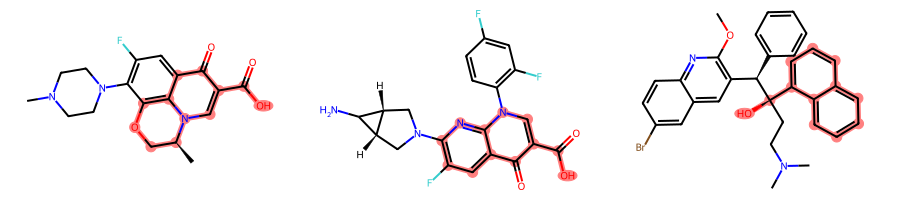

In [16]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

In [17]:
[m.GetSubstructMatches(mcs.queryMol) for m in mols]

[((1, 2, 6, 3, 7, 4, 8, 5, 9, 23, 11, 25),
  (5, 4, 6, 14, 7, 13, 8, 12, 9, 23, 11, 25)),
 ((9, 8, 10, 7, 11, 17, 13, 16, 14, 26, 15, 28),),
 ((9, 10, 8, 11, 7, 12, 6, 13, 15, 5, 14, 36),)]

However, if we instantiate the `CompareOrderOutsideRings` class setting the `aromatic_match_aromatic` optional parameter to `True`, the first molecule will match only on the quinoline ring system:

In [18]:
params = rdFMCS.MCSParameters()
params.AtomTyper = CompareElementsOutsideRings()
params.BondTyper = CompareOrderOutsideRings(True)
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True

In [19]:
mcs = rdFMCS.FindMCS(mols, params)

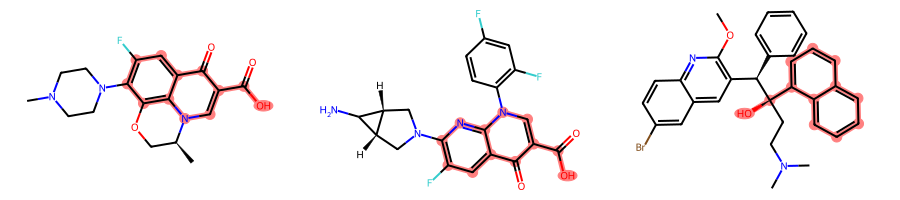

In [20]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

In [21]:
[m.GetSubstructMatches(mcs.queryMol) for m in mols]

[((4, 5, 14, 6, 13, 7, 12, 8, 11, 9, 23, 25),),
 ((8, 9, 7, 10, 17, 11, 16, 13, 15, 14, 26, 28),),
 ((10, 9, 11, 8, 12, 7, 13, 6, 14, 15, 5, 36),)]

# Retrieve all degenerate MCSs

It may happen that there are multiple degenerate MCSs (i.e., with the same size) across a set of molecules.<br>
Before my PR, the MCS algorithm implemented in RDKit would return only one of them, but which one would be rather unpredictable, as it depends on atom ordering in the molecules.<br>
This topic was raised during an RDKit UGM 2-3 years ago, but I did not realize its importance until one of my colleagues was bitten by the degenerate MCS issue.<br>
Now there is an optional `StoreAll` parameter, which defaults to `False`, which if set to `True` will trigger the storage of all degenerate MCSs in an array.<br>
See below for an example.

In [22]:
mols = [Chem.MolFromSmiles(smi) for smi in [
    "Nc1ccc(cc1)C-Cc1c(N)cccc1",
    "Nc1ccc(cc1)C=Cc1c(N)cccc1"]
]

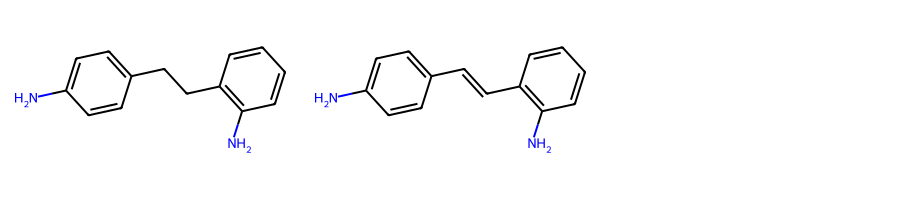

In [23]:
MolsToGridImage(mols, subImgSize=(300, 200))

You can see at a glance that two degenerate MCSs can be found between the above molecules, i.e., _o_-methylaniline and _p_-methylaniline.<br>
However, by default `rdFMCS` will only find one, in this case the _para_ isomer:

In [24]:
mcs = rdFMCS.FindMCS(mols)

In [25]:
mcs.numAtoms, mcs.numBonds

(8, 8)

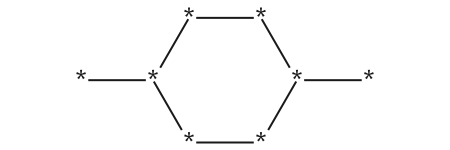

In [26]:
mcs.queryMol

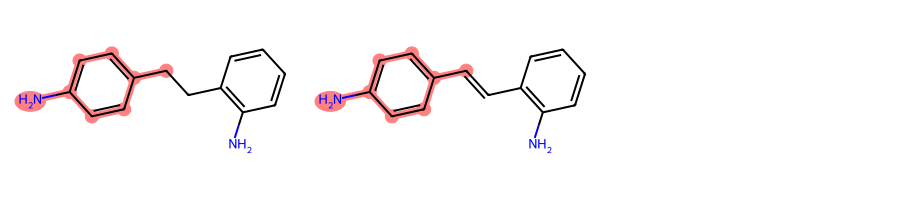

In [27]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

In [28]:
params = rdFMCS.MCSParameters()
params.StoreAll = True

In [29]:
mcs = rdFMCS.FindMCS(mols, params)

The number of atoms and bonds that constitute the MCS, as expected, are the same as before, since the MCSs are degenerate:

In [30]:
mcs.numAtoms, mcs.numBonds

(8, 8)

However, this time `mcs.queryMol` and `mcs.smartsString` are `None` and `''`, respectively.<br>
This is by design, as with `StoreAll` we need to be able to potentially access multiple MCSs, rather than only one as is the case for the `MCSResult.queryMol` and `MCSResult.smartsString` properties.<br>
The property that allows to browse all degenerate MCSs is `MCSResult.degenerateSmartsQueryMolDict`, which is a `dict`:

In [31]:
mcs.queryMol

In [32]:
mcs.smartsString

''

In [33]:
mcs.degenerateSmartsQueryMolDict

{'[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]': <rdkit.Chem.rdchem.Mol at 0x21594654c10>,
 '[#7]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]': <rdkit.Chem.rdchem.Mol at 0x215946550e0>}

Below I show all degenerate MCSs found, labelled with their respective SMARTS pattern:

In [34]:
mols_highlights_smarts_list = [[mols, [m.GetSubstructMatch(query) for m in mols], [smarts for _ in mols]] for smarts, query in mcs.degenerateSmartsQueryMolDict.items()]

In [35]:
mols_to_display, highlight_atom_lists, legends = [sum(item, []) for item in map(list, list(zip(*mols_highlights_smarts_list)))]

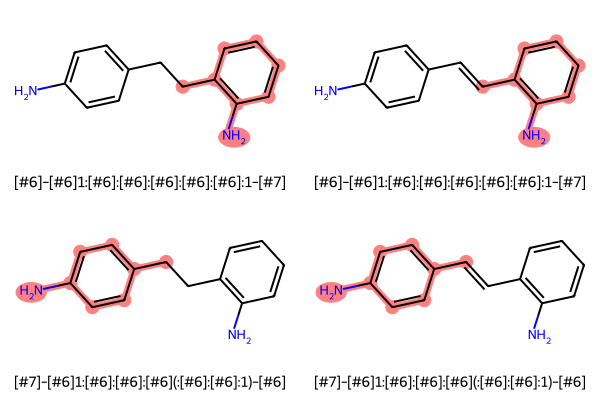

In [36]:
MolsToGridImage(mols_to_display, molsPerRow=2, subImgSize=(300, 200), highlightAtomLists=highlight_atom_lists, legends=legends)

# `FinalMatchChecker`

`MCSParameters.FinalMatchChecker` allows to implement a final check on a _growing_ MCS to determine whether it should be accepted (and eventually be allowed to grow further, if possible) or discarded.<br>
Just to clarify a bit, the MCS algorithm already implements some built-in, optional final match checkers, _e.g._ to check:
* stereochemistry, in case `MCSParameters.AtomCompareParameters.MatchChiralTag` is set to `True`
* ring fusion, in case `MCSParameters.BondCompareParameters.MatchFusedRings` is set to `True`

By implementing a custom class derived from `rdFMCS.MCSFinalMatchCheck` you may enforce your own check.<br>
For example, the following class will prevent any MCS containing nitrogen from growing further, causing it to be discarded straightaway:

In [37]:
class FinalMatchCheckNoNitrogen(rdFMCS.MCSFinalMatchCheck):
    def __call__(self, mol1, mol2, atom_idx_match, bond_idx_match, params):
        return not any(mol1.GetAtomWithIdx(mol1_atom_idx).GetAtomicNum() == 7
               or mol2.GetAtomWithIdx(mol2_atom_idx).GetAtomicNum() == 7
               for mol1_atom_idx, mol2_atom_idx in atom_idx_match)

Taking again as an example the two molecules from above, if we blacklist nitrogen we would expect the MCS to be toluene.

In [38]:
mols = [Chem.MolFromSmiles(smi) for smi in [
    "Nc1ccc(cc1)C-Cc1c(N)cccc1",
    "Nc1ccc(cc1)C=Cc1c(N)cccc1"]
]

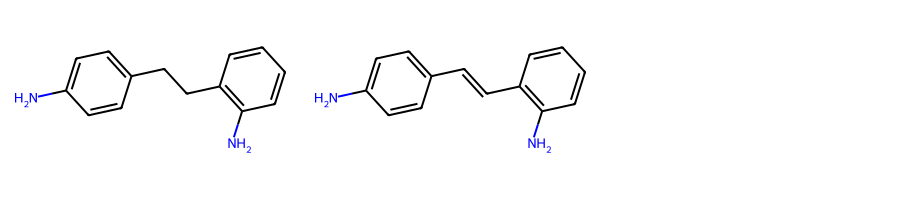

In [39]:
MolsToGridImage(mols, subImgSize=(300, 200))

In [40]:
params = rdFMCS.MCSParameters()
params.FinalMatchChecker = FinalMatchCheckNoNitrogen()

In [41]:
mcs = rdFMCS.FindMCS(mols, params)

The number of atoms and bonds that constitute the MCS, as expected, are the same as before, since the MCSs are degenerate:

In [42]:
mcs.numAtoms, mcs.numBonds

(7, 7)

And indeed, toluene is what we get:

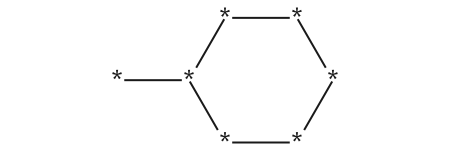

In [43]:
mcs.queryMol

In [44]:
mcs.smartsString

'[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]'

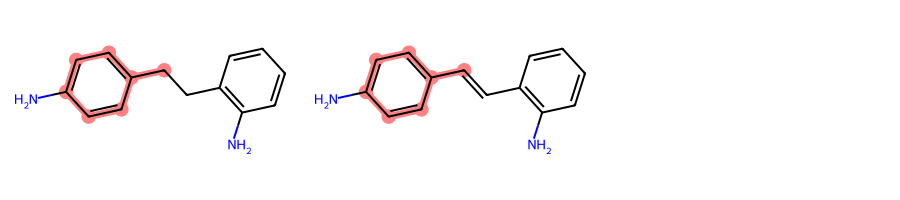

In [45]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

# `ShouldAcceptMCS`

`MCSParameters.ShouldAcceptMCS` allows to implement a user-defined acceptance criterion on a complete MCS (which is already fully grown and potentially ready to be returned as result).<br>
If the complete NCS fails the check, it will be discarded and not returned to the user.<br>
A quite specific use case that we recently had internally was to find an MCS between two molecules, one of which containing a dummy atom.<br>
We needed to enforce that, for the molecule containing the dummy atom, this dummy atom was actually part of the MCS.<br>
We did this by using a custom `TerminalDummyMatchesAnyNonTerminalAtom` `AtomCompare` subclass and a custom `EnforceDummyAcceptance` `MCSAcceptance` subclass; see below.

In [46]:
class TerminalDummyMatchesAnyNonTerminalAtom(rdFMCS.MCSAtomCompare):
    def __call__(self, p, mol1, atom1, mol2, atom2):
        a1 = mol1.GetAtomWithIdx(atom1)
        a2 = mol2.GetAtomWithIdx(atom2)
        a1_is_dummy = (a1.GetAtomicNum() == 0)
        a2_is_dummy = (a2.GetAtomicNum() == 0)
        if a1_is_dummy ^ a2_is_dummy:
            atoms = (a1, a2)
            dummy_atom_idx = 0 if a1_is_dummy else 1
            other_atom_idx = 1 - dummy_atom_idx
            return atoms[dummy_atom_idx].GetDegree() == 1 and atoms[other_atom_idx].GetDegree() > 1
        if a1.GetAtomicNum() != a2.GetAtomicNum():
            return False
        return self.CheckAtomRingMatch(p, mol1, atom1, mol2, atom2)

In [47]:
class EnforceDummyAcceptance(rdFMCS.MCSAcceptance):
    def __call__(self, mol1, mol2, atom_idx_match, bond_idx_match, params):
        for mol1_atom_idx, mol2_atom_idx in atom_idx_match:
            if mol1.GetAtomWithIdx(mol1_atom_idx).GetAtomicNum() == 0:
                return True 
            if mol2.GetAtomWithIdx(mol2_atom_idx).GetAtomicNum() == 0:
                return True
        return False

In [48]:
mols = [
    Chem.MolFromSmiles(smi) for smi in [
    "OC(=O)CCc1c(C)ccc2ccccc12",
    "c1(C)cc(cccc2)c2c(*)c1"
    ]
]

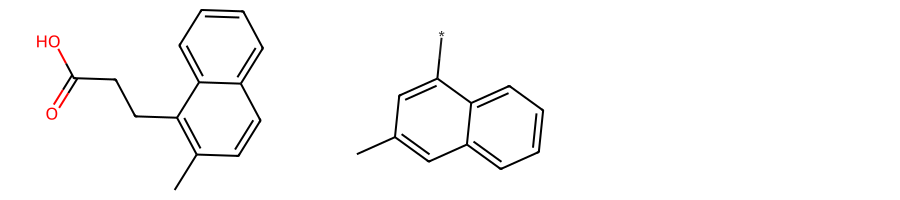

In [49]:
MolsToGridImage(mols, subImgSize=(300, 200))

If we set neither a custom `AtomCompare` class nor a custom `MCSAcceptance` but rather only request `BondCompareParameters.RingMatchesRingOnly` and `BondCompareParameters.CompleteRingsOnly` and set `StoreAll` to `True`, the only MCS found will be 2-naphthalene:

In [50]:
params = rdFMCS.MCSParameters()
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True
params.StoreAll = True

In [51]:
mcs = rdFMCS.FindMCS(mols, params)

In [52]:
mcs.numAtoms, mcs.numBonds

(11, 12)

In [53]:
len(mcs.degenerateSmartsQueryMolDict)

1

In [54]:
smarts_string, query_mol = tuple(mcs.degenerateSmartsQueryMolDict.items())[0]

In [55]:
smarts_string

'[#6]1(-&!@[#6]):&@[#6]:&@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2:&@[#6]:&@[#6]:&@1'

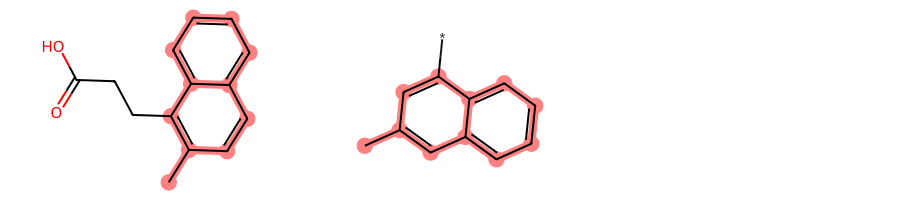

In [56]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(query_mol) for m in mols])

Instead, if in addiiton to the above we specify the custom `TerminalDummyMatchesAnyNonTerminalAtom` `AtomCompare` subclass allowing dummy atoms to match any other atom, we will find two degenerate MCSs:

In [57]:
params = rdFMCS.MCSParameters()
params.AtomTyper = TerminalDummyMatchesAnyNonTerminalAtom()
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True
params.StoreAll = True

In [58]:
mcs = rdFMCS.FindMCS(mols, params)

In [59]:
mcs.numAtoms, mcs.numBonds

(11, 12)

In [60]:
len(mcs.degenerateSmartsQueryMolDict)

2

In [61]:
mcs.degenerateSmartsQueryMolDict

{'[#6]1(-&!@[#6]):&@[#6]:&@[#6]:&@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2:&@[#6]:&@1': <rdkit.Chem.rdchem.Mol at 0x215946566c0>,
 '[#6]1:&@[#6]:&@[#6]2:&@[#6](:&@[#6](-&!@[#0,#6]):&@[#6]:&@1):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2': <rdkit.Chem.rdchem.Mol at 0x21594656810>}

Below I display I display all degenerate MCSs found, labelled with their respective SMARTS pattern:

In [62]:
mols_highlights_smarts_list = [[mols, [m.GetSubstructMatch(query) for m in mols], [smarts for _ in mols]] for smarts, query in mcs.degenerateSmartsQueryMolDict.items()]

In [63]:
mols_to_display, highlight_atom_lists, legends = [sum(item, []) for item in map(list, list(zip(*mols_highlights_smarts_list)))]

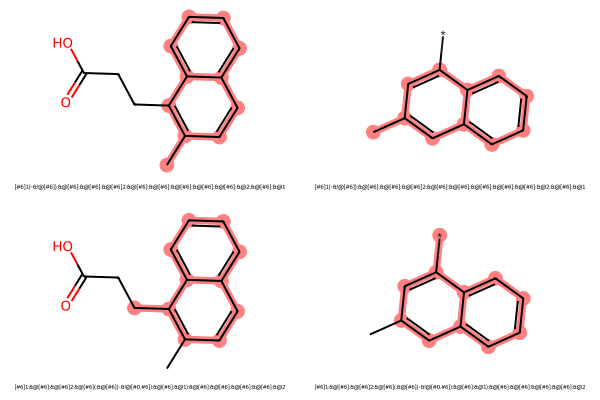

In [64]:
MolsToGridImage(mols_to_display, molsPerRow=2, subImgSize=(300, 200), highlightAtomLists=highlight_atom_lists, legends=legends)

As expected, since we allowed terminal dummies to match any non-terminal atom, we get both 1- and 2-naphthalene as degenerate MCSs.

Finally, if in addition to the above we also use `EnforceDummyAcceptance` as custom `MCSAcceptance` criterion enforcing that the dummy atom should be part of the MCS if possible, we will again get a single MCS, i.e. 1-naphthalene as it is the only one including the dummy atom:

In [65]:
params = rdFMCS.MCSParameters()
params.AtomTyper = TerminalDummyMatchesAnyNonTerminalAtom()
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True
params.ShouldAcceptMCS = EnforceDummyAcceptance()
params.StoreAll = True

In [66]:
mcs = rdFMCS.FindMCS(mols, params)

In [67]:
mcs.numAtoms, mcs.numBonds

(11, 12)

In [68]:
len(mcs.degenerateSmartsQueryMolDict)

1

In [69]:
smarts_string, query_mol = tuple(mcs.degenerateSmartsQueryMolDict.items())[0]

In [70]:
smarts_string

'[#6]1:&@[#6]:&@[#6]2:&@[#6](:&@[#6](-&!@[#0,#6]):&@[#6]:&@1):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2'

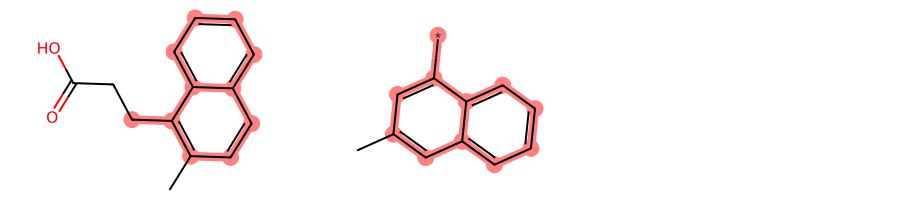

In [71]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(query_mol) for m in mols])